In [1]:
import sys
from pathlib import Path

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

if str(Path().resolve().parent) not in sys.path:
    sys.path.append(str(Path().resolve().parent))

from src.config import PAPER_DATASET_PATH, PREPROCESSED_PAPER_DATASET_PATH, BLOG_DATASET_PATH, \
    PREPROCESSED_BLOG_DATASET_PATH, DEEPMIND_BLOG_DATASET_PATH, PREPROCESSED_DEEPMIND_BLOG_DATASET_PATH, \
    CHARACTERS_PER_PAGE, MIN_PAGE_NUMBER
from src.text_extraction import extract_blog_text

# Dataset with Scientific Papers

In [2]:
papers = pd.read_csv(PAPER_DATASET_PATH)
papers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9680 entries, 0 to 9679
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   source_id  9680 non-null   int64 
 1   year       9680 non-null   int64 
 2   title      9680 non-null   object
 3   abstract   6361 non-null   object
 4   full_text  9677 non-null   object
dtypes: int64(2), object(3)
memory usage: 378.3+ KB


In [3]:
papers = papers[papers["abstract"].notna() & (papers["abstract"].str.strip() != "") &
                papers["full_text"].notna() & (papers["full_text"].str.strip() != "")]
papers.loc[:, "full_text_size"] = papers["full_text"].astype(str).apply(len)
papers = papers[(papers["full_text_size"] >= CHARACTERS_PER_PAGE * MIN_PAGE_NUMBER)]
papers.sort_values(by=["full_text_size", "year"], ascending=[True, False], inplace=True)
papers = papers.reset_index(drop=True)
papers = papers.drop(columns=["source_id", "year"])
papers = papers.loc[:73]
papers = papers.rename(columns={"full_text": "paper_full_text",
                                "title": "title_paper"})

In [4]:
papers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74 entries, 0 to 73
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   title_paper      74 non-null     object
 1   abstract         74 non-null     object
 2   paper_full_text  74 non-null     object
 3   full_text_size   74 non-null     int64 
dtypes: int64(1), object(3)
memory usage: 2.4+ KB


In [5]:
papers.to_csv(PREPROCESSED_PAPER_DATASET_PATH, index=False)

# Dataset with Medium Blogs

In [6]:
# Import data
blogs = pd.read_csv(BLOG_DATASET_PATH)

# Correcting URL of the paper if needed
blogs["url_paper"] = blogs["url_paper"].str.replace("abs", "pdf", regex=False)

# Handle blogs without additional publisher
blogs["publisher_followers"] = blogs["publisher_followers"].fillna(0)
blogs["publisher_blog"] = blogs["publisher_blog"].fillna(blogs["author_blog"])

In [7]:
# Scrape full blog texts
blogs["blog_full_text"] = blogs.apply(extract_blog_text, axis=1)

In [8]:
# Calculate engagement score
max_publisher_followers = blogs["publisher_followers"].max()
blogs["engagement_score"] = ((blogs["claps"] + 3 * blogs["comments"]) / np.log1p(blogs["author_followers"])) / (1 + blogs["publisher_followers"] / max_publisher_followers)

# Normalize engagement score
scaler = MinMaxScaler(feature_range=(0, 100))
blogs["normalized_engagement_score"] = scaler.fit_transform(blogs[["engagement_score"]]).flatten().round()

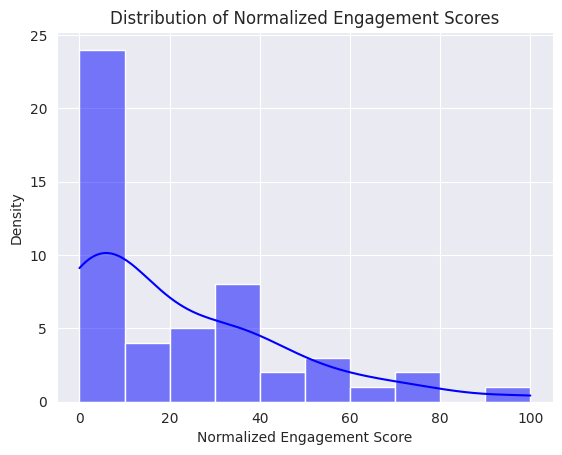

In [9]:
sns.histplot(blogs["normalized_engagement_score"], bins=10, kde=True, color="blue")
plt.xlabel("Normalized Engagement Score")
plt.ylabel("Density")
plt.title("Distribution of Normalized Engagement Scores")
plt.show()

In [10]:
# Logarithmize engagement score
blogs["engagement_score"] = np.log1p(blogs["engagement_score"])

# Normalize engagement score
scaler = MinMaxScaler(feature_range=(0, 100))
blogs["normalized_engagement_score"] = scaler.fit_transform(blogs[["engagement_score"]]).flatten().round()

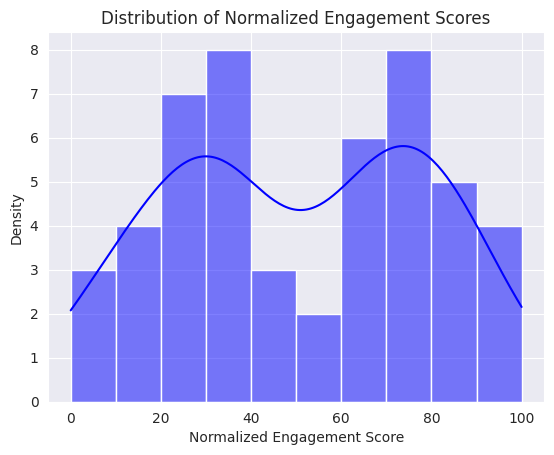

In [11]:
sns.histplot(blogs["normalized_engagement_score"], bins=10, kde=True, color="blue")
plt.xlabel("Normalized Engagement Score")
plt.ylabel("Density")
plt.title("Distribution of Normalized Engagement Scores")
plt.show()

In [12]:
def classify_blog(score):
    """Return blog classification based on engagement score."""
    if score >= 80:
        return "Excellent"
    elif score >= 65:
        return "Very Good"
    elif score >= 35:
        return "Good"
    elif score >= 20:
        return "Average"
    else:
        return "Bad"

blogs["engagement_level"] = blogs["normalized_engagement_score"].apply(classify_blog)
order = ["Bad", "Average", "Good", "Very Good", "Excellent"]
blogs["engagement_level"] = pd.Categorical(blogs["engagement_level"], categories=order, ordered=True)

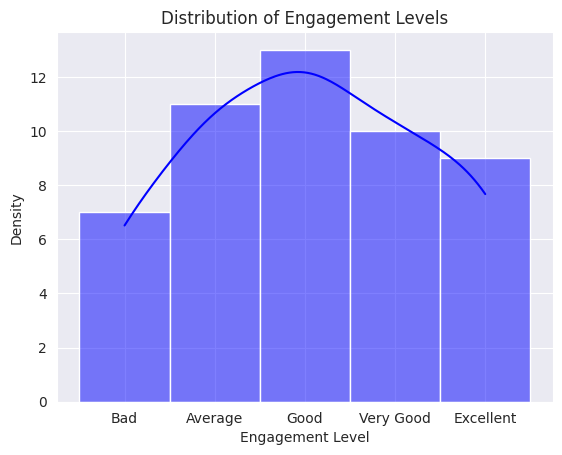

In [13]:
sns.histplot(blogs["engagement_level"], bins=5, kde=True, color="blue")
plt.xlabel("Engagement Level")
plt.ylabel("Density")
plt.title("Distribution of Engagement Levels")
plt.show()

In [14]:
blogs.to_csv(PREPROCESSED_BLOG_DATASET_PATH, index=False)

# Google Deepmind blogs

In [12]:
# Import
google_blogs = pd.read_csv(DEEPMIND_BLOG_DATASET_PATH)

In [15]:
# Scrape full blog text
google_blogs["blog_full_text"] = google_blogs["url_blog"].apply(lambda url: extract_blog_text(source="DeepMind", url_blog=url))

In [22]:
# Add "id" feature
google_blogs = google_blogs.reset_index(drop=False)
google_blogs.rename(columns={"index": "id"}, inplace=True)

In [39]:
def extract_title(blog):
    title_line = blog["blog_full_text"].splitlines()[0]
    index = title_line.find("# ")
    if index != -1:
        return title_line[index + 2:]
    else:
        return "Unknown"

In [40]:
# Add "title_blog" feature
google_blogs["title_blog"] = google_blogs.apply(extract_title, axis=1)

In [41]:
google_blogs.to_csv(PREPROCESSED_DEEPMIND_BLOG_DATASET_PATH, index=False)